# Hello, FABRIC: Create your first FABRIC slice

## Configure the Environment

Set the environment variable that will be used by this notebook. If you are using the FABRIC JupyterHub most of the environment will be automatically configured for you.  You will only need to set your bastion username, upload your bastion private key, and set the path to where you put your bastion private key. Your bastion username and private key should already be in your possession.  If you do not have a bastion username and private key, please contact the FABRIC admins using the [FABRIC User Forum](https://learn.fabric-testbed.net/forums/) 

If you are using the FABRIC API outside of the JupyterHub you will need to configure all of the environment variables. Defaults below will be correct in many situations but you will need to confirm your configuration.  If you have questions about this configuration, please contact the FABRIC admins using the [FABRIC User Forum](https://learn.fabric-testbed.net/forums/) 

More information about accessing your experiments through the FABRIC bastion hosts can be found [here](https://learn.fabric-testbed.net/knowledge-base/logging-into-fabric-vms/).

In [5]:
import os

os.environ['FABRIC_CREDMGR_HOST']='cm.fabric-testbed.net'
os.environ['FABRIC_ORCHESTRATOR_HOST']='orchestrator.fabric-testbed.net'
os.environ['FABRIC_TOKEN_LOCATION']=os.environ['HOME']+'/work/fabric_token.json'

os.environ['FABRIC_BASTION_USERNAME']='pruth'
os.environ['FABRIC_BASTION_KEY_LOCATION']=os.environ['HOME']+'/work/.ssh/id_rsa_fabric'

os.environ['FABRIC_SLICE_PRIVATE_KEY_FILE']=os.environ['HOME']+'/.ssh/id_rsa'
os.environ['FABRCI_SLICE_PUBLIC_KEY_FILE']=os.environ['HOME']+'/.ssh/id_rsa.pub'

os.environ['FABRIC_BASTION_HOST'] = 'bastion-1.fabric-testbed.net'
os.environ['FABRIC_BASTION_HOST_PRIVATE_IPV4'] = '192.168.11.226'
os.environ['FABRIC_BASTION_HOST_PRIVATE_IPV6'] = '2600:2701:5000:a902::c'

#### Read the SSH Key File

In [6]:
slice_private_key_file=os.environ['FABRIC_SLICE_PRIVATE_KEY_FILE']
slice_public_key_file=os.environ['FABRCI_SLICE_PUBLIC_KEY_FILE']

slice_public_key = None
with open (slice_public_key_file, "r") as myfile:
    slice_public_key=myfile.read().strip()
    

## Setup the Experiment

#### Import FABRIC API

In [7]:
import os
from fabrictestbed.slice_manager import SliceManager, Status, SliceState
import json

#### Create the FABRIC Proxies

The FABRIC API is used via proxy objects that manage connections to the control framework.  

In [8]:
slice_manager = SliceManager(oc_host=os.environ['FABRIC_ORCHESTRATOR_HOST'], 
                             cm_host=os.environ['FABRIC_CREDMGR_HOST'] ,
                             project_name='all', 
                             scope='all')

# Initialize the slice manager
slice_manager.initialize()

#### (Optional) Query Available Resources

This optional command queries the FABRIC services to find the available resources. It may be useful for finding a site with available capacity.

In [9]:
return_status, advertised_topology = slice_manager.resources()

if return_status == Status.OK:
    print(f"Toplogy: {advertised_topology}")
else:
    print(f"Error: {advertised_topology}")

Toplogy: NCSA: { cpu: 6/6 , core: 180/192 , ram: 1,476/1,536 G, disk: 60,300/60,600 G, unit: 3/3 }
	Components:
		NVME-P4510:  NVME P4510 { disk: 8,640/9,600 G, unit: 9/10 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 2/2 }
		GPU-RTX6000:  GPU RTX6000 { unit: 3/3 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2/2 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 378/381 }
	Site Interfaces:
		NCSA_STAR: TrunkPort { bw: 100/100 Gbps}
TACC: { cpu: 10/10 , core: 320/320 , ram: 2,560/2,560 G, disk: 116,400/116,400 G, unit: 5/5 }
	Components:
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 4/4 }
		GPU-RTX6000:  GPU RTX6000 { unit: 6/6 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		NVME-P4510:  NVME P4510 { disk: 15,360/15,360 G, unit: 16/16 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 635/635 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2 }
	Site Interfaces:
		TACC_UTAH: TrunkPort { bw: 100/100 Gbps}


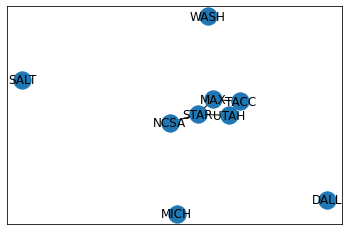

In [10]:
if return_status == Status.OK:
    advertised_topology.draw()

## Create the Experiment Slice

#### Configure the Experiment Parameters



In [11]:
slice_name = 'MySlice'
site = 'MAX'
node_name = 'Node1'
username = 'centos'
image = 'default_centos_8'
image_type = 'qcow2'
cores = 2
ram = 2
disk = 2

### Create Slice

Creates a single node with basic compute capabilities.

<img src="./figs/SingleNode.png" width="40%"><br>


In [12]:
from fabrictestbed.slice_editor import ExperimentTopology, Capacities, ComponentType, ComponentModelType, ServiceType, Labels
# Create topology
experiment = ExperimentTopology()

# Add node
node = experiment.add_node(name=node_name, site=site)

# Set capacities
cap = Capacities()
cap.set_fields(core=cores, ram=ram, disk=disk)

# Set Properties
node.set_properties(capacities=cap, image_type=image_type, image_ref=image)

# Generate Slice Graph
slice_graph = experiment.serialize()

# Request slice from Orchestrator
return_status, slice_reservations = slice_manager.create(slice_name=slice_name, slice_graph=slice_graph, ssh_key=slice_public_key)

if return_status == Status.OK:
    slice_id = slice_reservations[0].get_slice_id()
    print("Submitted slice creation request. Slice ID: {}".format(slice_id))
else:
    print(f"Failure: {slice_reservations}")

Submitted slice creation request. Slice ID: 31c2ee41-0a73-458c-bb10-650e255cee28


### Query Slices

You can get a list of all your slices from the slice manager. If this is your first slice, it should return only one slice.

<div class="alert alert-block alert-info">
<b>Note:</b> The status returned by the call to slices indicates the success or failure of the call to the FABRIC control framework. The status is not the status of the slices.  The status of each slice is included in the list of slices.
</div>



 

In [13]:
return_status, slices = slice_manager.slices(excludes=[SliceState.Dead,SliceState.Closing])

if return_status == Status.OK:
    for slice in slices:
        print("{}:".format(slice.slice_name))
        print("   ID         : {}".format(slice.slice_id))
        print("   State      : {}".format(slice.slice_state))
        print("   Lease End  : {}".format(slice.lease_end))
        print()
else:
    print(f"Failure: {slices}")

MySliceUbuntu1:
   ID         : eff7edf3-335f-4a3b-aa49-78ec0cf96a90
   State      : StableOK
   Lease End  : 2021-12-15 16:36:43

MySlice:
   ID         : 31c2ee41-0a73-458c-bb10-650e255cee28
   State      : Configuring
   Lease End  : 2021-12-15 19:16:11



### Get the New Slice

Your new slice is in the list of all your slices. You can loop through the list of slices to get the new slice. Python has a standard tool to filter lists. Try using a lambda function to filter out your slice using its name.

In [14]:
slice = list(filter(lambda x: x.slice_name == slice_name, slices))[0]

print("Slice Name : {}".format(slice.slice_name))
print("ID         : {}".format(slice.slice_id))
print("State      : {}".format(slice.slice_state))
print("Lease End  : {}".format(slice.lease_end))

Slice Name : MySlice
ID         : 31c2ee41-0a73-458c-bb10-650e255cee28
State      : Configuring
Lease End  : 2021-12-15 19:16:11


### Wait for the Slice to Build

In [15]:
import time
def wait_for_slice(slice,timeout=180,interval=10,progress=False):
    timeout_start = time.time()

    if progress: print("Waiting for slice .", end = '')
    while time.time() < timeout_start + timeout:
        return_status, slices = slice_manager.slices(excludes=[SliceState.Dead,SliceState.Closing])

        if return_status == Status.OK:
            slice = list(filter(lambda x: x.slice_name == slice_name, slices))[0]
            if slice.slice_state == "StableOK":
                if progress: print(" Slice state: {}".format(slice.slice_state))
                return slice
            if slice.slice_state == "Closing" or slice.slice_state == "Dead":
                if progress: print(" Slice state: {}".format(slice.slice_state))
                return slice    
        else:
            print(f"Failure: {slices}")
        
        if progress: print(".", end = '')
        time.sleep(interval)
    
    if time.time() >= timeout_start + timeout:
        if progress: print(" Timeout exceeded ({} sec). Slice: {} ({})".format(timeout,slice.slice_name,slice.slice_state))
        return slice    

            
            
slice = wait_for_slice(slice, progress=True)
print()

print("Slice Name : {}".format(slice.slice_name))
print("ID         : {}".format(slice.slice_id))
print("State      : {}".format(slice.slice_state))
print("Lease End  : {}".format(slice.lease_end))

Waiting for slice ...... Slice state: StableOK

Slice Name : MySlice
ID         : 31c2ee41-0a73-458c-bb10-650e255cee28
State      : StableOK
Lease End  : 2021-12-15 19:16:11


### Get the Slice Topology

In [ ]:
return_status, experiment_topology = slice_manager.get_slice_topology(slice_object=slice)

for node_name, node in experiment_topology.nodes.items():
    print("Node:")
    print("   Name              : {}".format(node.name))
    print("   Cores             : {}".format(node.get_property(pname='capacity_allocations').core))
    print("   RAM               : {}".format(node.get_property(pname='capacity_allocations').ram))
    print("   Disk              : {}".format(node.get_property(pname='capacity_allocations').disk))
    print("   Image             : {}".format(node.image_ref))
    print("   Image Type        : {}".format(node.image_type))
    print("   Host              : {}".format(node.get_property(pname='label_allocations').instance_parent))
    print("   Site              : {}".format(node.site))
    print("   Management IP     : {}".format(node.management_ip))
    print("   Reservation ID    : {}".format(node.get_property(pname='reservation_info').reservation_id))
    print("   Reservation State : {}".format(node.get_property(pname='reservation_info').reservation_state))
    print("   Components        : {}".format(node.components))
    print("   Interfaces        : {}".format(node.interfaces))
    print()    


## Accessing the VM

#### Terminal SSH Command

Connecting to your VMs requests you to jump through the bastion host to the VM using the keys configured above. From a terminal you can ssh to the VM using the command generated by the following command.


In [ ]:
print('ssh -i {} -J {}@{} {}@{}'.format(slice_private_key_file,
                                           os.environ['FABRIC_BASTION_USERNAME'],
                                           os.environ['FABRIC_BASTION_HOST'],
                                           username,
                                           node.management_ip))

#### SSH with Python (paramiko)

Most experiments will require automated configuration and execution. You can use the paramiko Python library to execute arbitrary commands on your VMs. 

The following cells use paramiko to execute a "Hello, FABRIC" bash script. The cell uses the bastion and VM keys defined at the top of this notebook to jump through the bastion host and execute the script.


In [ ]:
script= '#!/bin/bash  \n' \
        'echo Hello, FABRIC from node `hostname -s`   \n'

In [ ]:
from ipaddress import ip_address, IPv4Address
def validIPAddress(IP: str) -> str:
    try:
        return "IPv4" if type(ip_address(IP)) is IPv4Address else "IPv6"
    except ValueError:
        return "Invalid"

import paramiko
for node_name, node in experiment_topology.nodes.items():
    try:
        management_ip = str(node.get_property(pname='management_ip'))
        print("Node {0} IP {1}".format(node_name, management_ip))

        key = paramiko.RSAKey.from_private_key_file(slice_private_key_file)

        bastion=paramiko.SSHClient()
        bastion.set_missing_host_key_policy(paramiko.AutoAddPolicy())
        bastion.connect(os.environ['FABRIC_BASTION_HOST'], 
                        username=os.environ['FABRIC_BASTION_USERNAME'], 
                        key_filename=os.environ['FABRIC_BASTION_KEY_LOCATION'])

    
        bastion_transport = bastion.get_transport()
        if validIPAddress(management_ip) == 'IPv4':
            src_addr = (os.environ['FABRIC_BASTION_HOST_PRIVATE_IPV4'], 22)
        elif validIPAddress(management_ip) == 'IPv6':
            src_addr = (os.environ['FABRIC_BASTION_HOST_PRIVATE_IPV6'], 22)
        else:
            print('Management IP Invalid: {}'.format(management_ip))

        dest_addr = (management_ip, 22)
        bastion_channel = bastion_transport.open_channel("direct-tcpip", dest_addr, src_addr)


        client = paramiko.SSHClient()
        client.load_system_host_keys()
        client.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())
        client.set_missing_host_key_policy(paramiko.AutoAddPolicy())

        client.connect(management_ip,username=username,pkey = key, sock=bastion_channel)

        stdin, stdout, stderr = client.exec_command('echo \"' + script + '\" > script.sh; chmod +x script.sh; sudo ./script.sh')
        print ('')
        print (str(stdout.read(),'utf-8').replace('\\n','\n'))

        client.close()
    except Exception as e:
        print(str(e))



## Delete Slice

In [ ]:
return_status, result = slice_manager.delete(slice_object=slice)

print("Response Status {}".format(return_status))
print("Response received {}".format(result))